In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hyperopt import hp
from hyperopt import fmin, rand, tpe, atpe, STATUS_OK, STATUS_FAIL, Trials

from pylab import meshgrid, cm, imshow, contour, clabel, colorbar, axis, title, show

In [2]:
def plot_function(f, h_axis=None, export_path=None, title=None):
    if h_axis is None:
        h_axis = np.arange(-5, 5, .01)
        
    if title is None:
        title = 'График функции f(x)'
        
    v_axis = f(h_axis)
    plt.plot(h_axis, v_axis)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.show()
    
    if export_path is not None:
        plt.savefig(export_path)

In [3]:
def plot_2d_function(f, x_min=0, y_min=5, x_max=5, y_max=5, step=.1, export_path=None, title=None):        
    if title is None:
        title = 'График функции f(x)'
        
    x = np.arange(x_min, x_max, step)
    y = np.arange(y_max, y_min, -step)
    X, Y = meshgrid(x, y)
    Z = f(X, Y)
    
    im = plt.imshow(Z, cmap='RdBu', extent = [x_min, x_max, y_min, y_max])
    plt.xticklabels = X
    plt.yticklabels = Y
    plt.colorbar(im)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
    if export_path is not None:
        plt.savefig(export_path)

# Сходимость алгоритмов оптимизации гиперпараметров

Работая с различными алгоритмами оптимизации гиперпараметров, столкнулся с проблемой, что сходимость либо не наступает, либо очень долгая (так что краткосрочная дисперсия практически не убывает). Возникает вопрос: какой алгоритм / библиотека, как нам кажется, является в этом смысле оптимальной? Мы планируем проверить следующие подходы:

1. Hyperopt:
    * Random Search
    * Tree of Parzen Estimators (TPE)
    * Adaptive TPE
2. Optuna
3. Scikit-learn
4. Ray-tune

Саму оптимизацию будем проводить в два шага. Сначала проверим результаты на нескольких примерах, где мы аналитически сможем получить глобальный минимум. Затем (work in progress - WIP) повторно проведём эксперимент на реальных данных.

# Эксперименты на искусственных данных

## Описание эксперимента

Рассмотрим функцию

$$z = (x-2)^2 \cdot (x-6)^2 + (y-3)^2 \cdot (y-7)^2 + 0.1 \cdot (|x-6| + |y-7|) $$

Функция подобрана таким образом, чтобы минимум достигался в точке $(6, 7)$, однако существовали локальные минимумы в точках $(2, 3), (2, 7), (6, 7)$. Объясняется это тем, что первые два слагаемых имеют минимумы в точках $x = \{2, 6\}, y = \{3, 7\}$. Без последнего слагаемого у нас бы было 4 глобальных минимума. Поскольку последнее слагаемое достигает минимума в точке (6, 7), оно оттягивает глобальный минимум в эту точку.

## Hyperopt

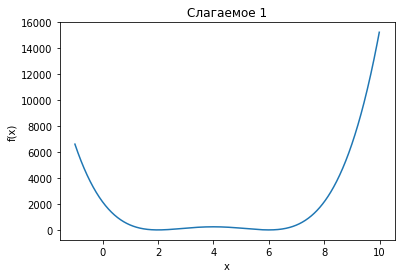

In [4]:
def exp1_f1(x):
    return 15 * (x-2) ** 2 * ((x-6) ** 2)

plot_function(exp1_f1, np.arange(-1, 10, .01), title='Слагаемое 1')

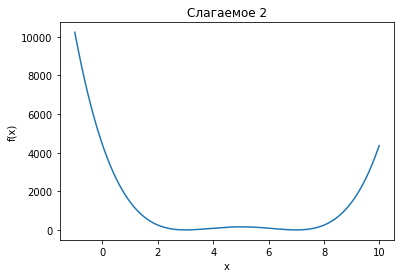

In [40]:
def exp1_f2(x):
    return 10 * (x-3) ** 2 * ((x-7) ** 2)

plot_function(exp1_f2, np.arange(-1, 10, .01), title='Слагаемое 2')

In [6]:
def exp1_f3(x, y):
    return .1 * (np.abs(x-6) + np.abs(y-7))

In [7]:
exp1_f3(6,7)

0.0

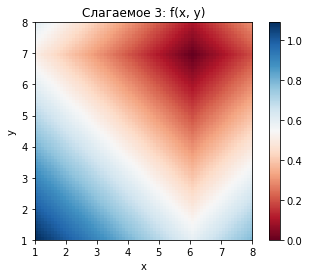

In [8]:
plot_2d_function(exp1_f3, x_min=1, y_min=1, x_max=8, y_max=8, step=.1, title='Слагаемое 3: f(x, y)')

Итоговая функция (очевидны 4 минимума, из которых только 1 глобальный):

In [43]:
def exp1_f(x, y):
    return (exp1_f1(x) + exp1_f2(y) + exp1_f3(x, y)) ** .25

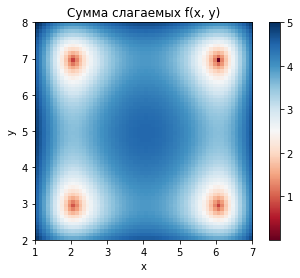

In [44]:
plot_2d_function(exp1_f, x_min=1, y_min=2, x_max=7, y_max=8, step=.1, title='Сумма слагаемых f(x, y)')

Проверка:

In [11]:
exp1_f(6,7)

0.0

In [12]:
exp1_f(6,3)

0.7952707287670506

In [13]:
exp1_f(2,7)

0.7952707287670506

In [14]:
exp1_f(2,3)

0.9457416090031758

## Hyperopt

### TPE + discrete space

In [15]:
def exp1_f_wrapper(args):
    # print(args)
    x, y = args
    return({'loss': exp1_f(x, y), 'status': STATUS_OK, 'x': x, 'y': y})

In [16]:
trials = Trials()
best = fmin(exp1_f_wrapper,
    space = (
        hp.choice('x', np.arange(1, 8, .01)),
        hp.choice('y', np.arange(1, 8, .01))
    ),
    algo=tpe.suggest,
    trials=trials,
    max_evals=1000)

print(best)

100%|████████████████████████████████████████████| 1000/1000 [01:37<00:00, 10.25trial/s, best loss: 0.8014795331061642]
{'x': 504, 'y': 599}


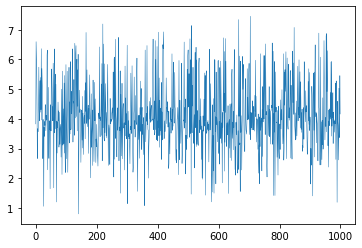

In [17]:
plt.plot(trials.losses(), linewidth=.5)

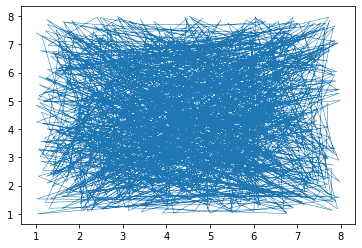

In [18]:
plt.plot(
[trials.results[i]['x'] for i in range(len(trials.results))],
[trials.results[i]['y'] for i in range(len(trials.results))],
linewidth=.5
)

### TPE + continuous space

In [19]:
trials = Trials()
best = fmin(exp1_f_wrapper,
    space = (
        hp.uniform('x', 1, 8),
        hp.uniform('y', 1, 8)
    ),
    algo=tpe.suggest,
    trials=trials,
    max_evals=1000)

print(best)

100%|███████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.44trial/s, best loss: 0.8008103635657896]
{'x': 6.0059525797150926, 'y': 2.996646611127802}


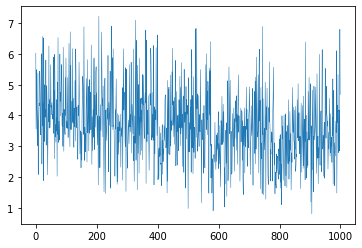

In [20]:
plt.plot(trials.losses(), linewidth=.5)

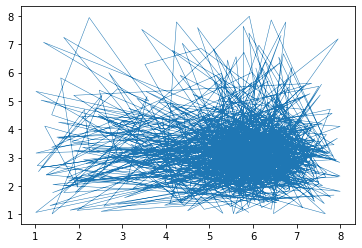

In [21]:
plt.plot(
[trials.results[i]['x'] for i in range(len(trials.results))],
[trials.results[i]['y'] for i in range(len(trials.results))],
linewidth=.5
)

### ATPE + continuous space

In [22]:
trials = Trials()
best = fmin(exp1_f_wrapper,
    space = (
        hp.uniform('x', 1, 8),
        hp.uniform('y', 1, 8)
    ),
    algo=atpe.suggest,
    trials=trials,
    max_evals=1000)

print(best)

100%|█████████████████████████████████████████████| 1000/1000 [05:36<00:00,  2.97trial/s, best loss: 0.795822571682594]
{'x': 2.0001919825412973, 'y': 7.0023524833909905}


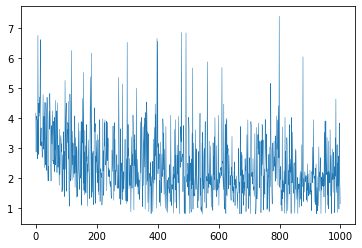

In [23]:
plt.plot(trials.losses(), linewidth=.5)

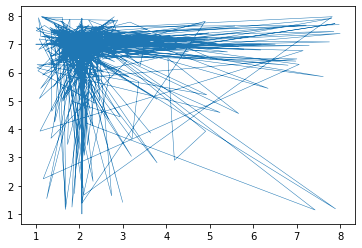

In [24]:
plt.plot(
[trials.results[i]['x'] for i in range(len(trials.results))],
[trials.results[i]['y'] for i in range(len(trials.results))],
linewidth=.5
)

### Random Search + continuous space

In [25]:
trials = Trials()
best = fmin(exp1_f_wrapper,
    space = (
        hp.uniform('x', 1, 8),
        hp.uniform('y', 1, 8)
    ),
    algo=rand.suggest,
    trials=trials,
    max_evals=1000)

print(best)

100%|███████████████████████████████████████████| 1000/1000 [00:01<00:00, 752.89trial/s, best loss: 0.8432557991578835]
{'x': 6.010376068594642, 'y': 7.053666203437161}


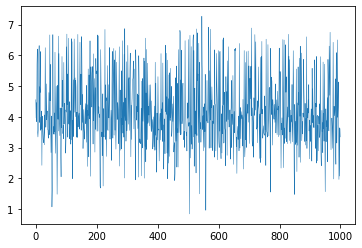

In [26]:
plt.plot(trials.losses(), linewidth=.5)

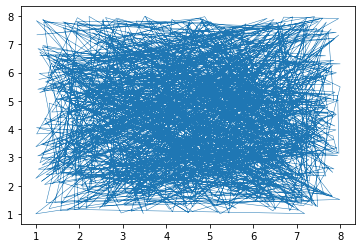

In [27]:
plt.plot(
[trials.results[i]['x'] for i in range(len(trials.results))],
[trials.results[i]['y'] for i in range(len(trials.results))],
linewidth=.5
)

## Optuna

In [28]:
import optuna

def objective(trial):
    x = trial.suggest_float('x', 1, 8)
    y = trial.suggest_float('y', 1, 8)
    return exp1_f(x, y)

### TPE

In [29]:
study = optuna.create_study()
study.optimize(objective, n_trials=1000)
print(f"Sampler is {study.sampler.__class__.__name__}")

study.best_params # E.g. {'x': 2.002108042}

[I 2021-12-11 12:02:32,939] A new study created in memory with name: no-name-62db9e7c-b381-4b8f-8968-0ef913a2f956
[I 2021-12-11 12:02:32,939] Trial 0 finished with value: 3.3580865091159167 and parameters: {'x': 1.9917696876025528, 'y': 5.664612513379095}. Best is trial 0 with value: 3.3580865091159167.
[I 2021-12-11 12:02:32,947] Trial 1 finished with value: 2.4245004173370406 and parameters: {'x': 2.3134192048127478, 'y': 2.7258386526605367}. Best is trial 1 with value: 2.4245004173370406.
[I 2021-12-11 12:02:32,947] Trial 2 finished with value: 3.8675903453373954 and parameters: {'x': 3.4813662537843753, 'y': 3.3257147403952634}. Best is trial 1 with value: 2.4245004173370406.
[I 2021-12-11 12:02:32,947] Trial 3 finished with value: 3.4293181696826838 and parameters: {'x': 5.908754436832043, 'y': 4.442845838612426}. Best is trial 1 with value: 2.4245004173370406.
[I 2021-12-11 12:02:32,947] Trial 4 finished with value: 6.037521268266961 and parameters: {'x': 2.6925241692966075, 'y':

Sampler is TPESampler


{'x': 5.997322947865237, 'y': 7.002553087695482}

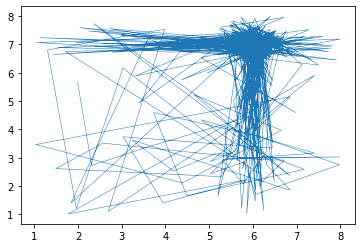

In [30]:
plt.plot(
    [study.trials[i].params['x'] for i in range(1000)],
    [study.trials[i].params['y'] for i in range(1000)],
    linewidth=.5
)

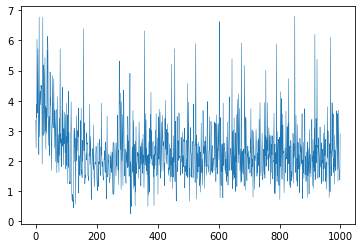

In [31]:
plt.plot([study.trials[i].values for i in range(1000)], linewidth=.5)

### Random Search

In [32]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=1000)
print(f"Sampler is {study.sampler.__class__.__name__}")

study.best_params # E.g. {'x': 2.002108042}

[I 2021-12-11 12:05:24,825] A new study created in memory with name: no-name-ee589e7c-c5bd-4cf3-9e6c-a2bb8d20b639
[I 2021-12-11 12:05:24,832] Trial 0 finished with value: 4.73284627435709 and parameters: {'x': 6.032222959898801, 'y': 1.671655682055152}. Best is trial 0 with value: 4.73284627435709.
[I 2021-12-11 12:05:24,833] Trial 1 finished with value: 3.58763658282313 and parameters: {'x': 2.556783268559766, 'y': 4.172501046142489}. Best is trial 1 with value: 3.58763658282313.
[I 2021-12-11 12:05:24,834] Trial 2 finished with value: 7.0670075602232645 and parameters: {'x': 7.777209631416392, 'y': 1.3188065287419217}. Best is trial 1 with value: 3.58763658282313.
[I 2021-12-11 12:05:24,835] Trial 3 finished with value: 4.415135724154093 and parameters: {'x': 3.5828011903425976, 'y': 4.985216061026499}. Best is trial 1 with value: 3.58763658282313.
[I 2021-12-11 12:05:24,836] Trial 4 finished with value: 4.684244279836019 and parameters: {'x': 6.985916566451961, 'y': 2.27212642449222

Sampler is RandomSampler


{'x': 2.0244457815742, 'y': 7.0035081269964135}

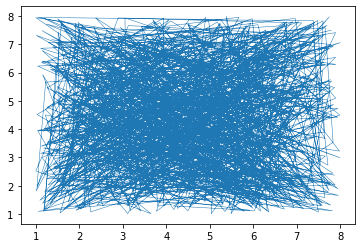

In [33]:
plt.plot(
    [study.trials[i].params['x'] for i in range(1000)],
    [study.trials[i].params['y'] for i in range(1000)],
    linewidth=.5
)

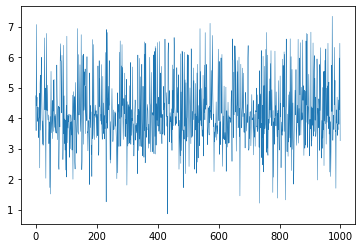

In [34]:
plt.plot([study.trials[i].values for i in range(1000)], linewidth=.5)

### CmaEsSampler

In [35]:
study = optuna.create_study(sampler=optuna.samplers.CmaEsSampler())
study.optimize(objective, n_trials=1000)
print(f"Sampler is {study.sampler.__class__.__name__}")

study.best_params # E.g. {'x': 2.002108042}

[I 2021-12-11 12:08:03,397] A new study created in memory with name: no-name-561a9b78-a6af-4568-a9e0-8d2141527fde
[I 2021-12-11 12:08:03,405] Trial 0 finished with value: 4.058284953417165 and parameters: {'x': 3.20565561716466, 'y': 5.910015673546073}. Best is trial 0 with value: 4.058284953417165.
[I 2021-12-11 12:08:03,435] Trial 1 finished with value: 4.238163349231901 and parameters: {'x': 3.5022925349308514, 'y': 2.2930740464145445}. Best is trial 0 with value: 4.058284953417165.
[I 2021-12-11 12:08:03,435] Trial 2 finished with value: 4.305806193223371 and parameters: {'x': 4.02178836263428, 'y': 4.113459074566216}. Best is trial 0 with value: 4.058284953417165.
[I 2021-12-11 12:08:03,443] Trial 3 finished with value: 2.611958879029076 and parameters: {'x': 2.3199401680544294, 'y': 3.4450019921443666}. Best is trial 3 with value: 2.611958879029076.
[I 2021-12-11 12:08:03,443] Trial 4 finished with value: 3.463097398914518 and parameters: {'x': 5.506035184485983, 'y': 4.071821815

Sampler is CmaEsSampler


{'x': 6.0, 'y': 3.0003125735722267}

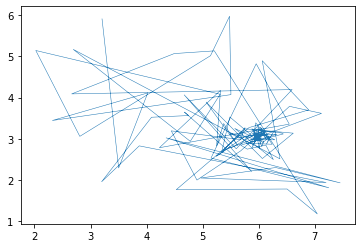

In [38]:
plt.plot(
    [study.trials[i].params['x'] for i in range(1000)],
    [study.trials[i].params['y'] for i in range(1000)],
    linewidth=.5
)

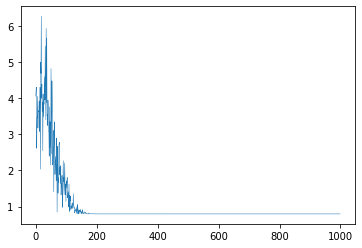

In [39]:
plt.plot([study.trials[i].values for i in range(1000)], linewidth=.5)

## Scikit-learn

Work in Progress

## Ray-tune

Work in progress

# Эксперименты на реальных данных

Work in Progress